<a href="https://colab.research.google.com/github/mzhkz/coefont_kana_convert_error_detector/blob/main/0904_detect_kana_yomi_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前準備
## 必要なパッケージ等を読み込み/割り当て

In [ ]:
! pip install mecab-python3 unidic-lite
! pip install plyvel
! pip install sseclient
! pip install wikipedia-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import requests as reqs
import json
import regex
import plyvel
import pickle
import MeCab
import datetime
import wikipediaapi
import re
import multiprocessing as mp
from tqdm import tqdm
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from sseclient import SSEClient as EventSource

## 作業ディレクトリ（ファイルの読み込みや保存を行う絶対パス）

In [ ]:
APP_WORKDIR = "/content/drive/MyDrive/coefont_kana_converter_error_detector/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### APIのアクセストークンなど機密情報の管理

In [369]:
secrets = {}
with open(APP_WORKDIR + 'secrets.json') as f:
  secrets = json.load(f)

### Spreadsheetのクライアントを取得

In [370]:
auth_scope =['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
auth_creds = ServiceAccountCredentials.from_json_keyfile_name(APP_WORKDIR + 'client_secret.json', auth_scope)
spreadsheet_client = gspread.authorize(auth_creds)

In [371]:
spreadsheet = spreadsheet_client.open_by_key(secrets["coefont_logging_spreadsheet_id"]).sheet1

## データベースのセットアップ（品詞の保存）
* APIのアクセス量を減らすため、過去に変換を行った単語をデータベースに保存し、キャッシュとして利用する。
* 読み書きの早い、Key -> Value型のローカルファイル型データベースである。
* Ethereumのノードの内部ではトランザクションの管理とかでも使われている。
* https://github.com/google/leveldb
* https://plyvel.readthedocs.io/en/latest/

In [ ]:
vocab_db = plyvel.DB(APP_WORKDIR + 'vocabs.ldb', create_if_missing=True)
lebels_db = plyvel.DB(APP_WORKDIR + 'lebels.ldb', create_if_missing=True)
checked_db = plyvel.DB(APP_WORKDIR + 'checked.ldb', create_if_missing=True)

dbs = [vocab_db, lebels_db, checked_db]

### パスを間違えたりして再読み込みする場合は以下セルを実行してから上のセルを実行する

In [ ]:
for db in dbs:
  db.close()

## 各種依存記号の設定

In [ ]:
SYMBOL_READING_POINT = "、" # 句読点
SYMBOL_PUNCTUATION = "。" # 読点
SYMBOL_HALF_SPACE = " " # 半角スペース
SYMBOL_LONG_NOTE = "ー" # 伸ばし棒
SYMBOL_NONE = "" # 空文字
SYMBOL_TAB = "\t" # TAB
SYMBOL_SEMICORON = ";" # SEMICORON

# データソース別のクラス
* 単語中抽出に必要な対象（Webページなど）を管理する
* 名詞の抽出とMeCabによるよみラベルを管理する。

## 要件
*   Webサイトからテキストをスクレイピング（Webサイトごとにテンプレートを作成する）
*   リンクや特殊記号を排除する
*   文章の形態素解析を行い、漢字が含まれている名詞のみを抽出する。



### MecabのWakatiで初期化

In [ ]:
wakati = MeCab.Tagger()

### 漢字判定用の正規表現

In [ ]:
KANJI_REG_PETERN = regex.compile(r'\p{Script=Han}')

## ローダー

単語抽出要件
*   MeCabで名詞判定されたもの
*   漢字が2文字以上含まれているもの
  * 「月」を「げつ」や「がっ」などコンテクストに基づく誤字判定が多くなってしまうため
  * 常用の漢字 1文字で音読み・訓読みの違いがあるため



In [319]:
class DataSource:
  def __init__(self):
    self.vocabs = []
    self.labels = [] 

  def _fetchData(self): # 文章（テキストデータ）を読み込む、ここは各サービスごとに取得の方法が異なるためオーバーライドする。
    pass

  def preprosessing(self, subject):
    handled = self._replaceSymbol(subject) #ここから文字列
    return handled

  def _replaceSymbol(self, subject):
    sentence = subject.replace(SYMBOL_TAB, SYMBOL_NONE)
    return sentence

  def load(self):
    text = self._fetchData()
    text = self.preprosessing(text)
    vocabs, labels = self._analysis(text)
    self.vocabs = vocabs
    self.labels = labels 

  def _analysis(self, subject):
    result = wakati.parse(subject) # 形態素解析分析 tab分けで結果が出てくる
    vocabs = [line.split(SYMBOL_TAB) for line in result.splitlines()]
    nouns = [vocab_data for vocab_data in vocabs if len(vocab_data) >= 4 and "名詞" in vocab_data[4][0:2] and len(KANJI_REG_PETERN.findall(vocab_data[0])) >= 2] # 2つの漢字を含む名詞のみ抽出
    nouns, labels = [re.escape(noun[0]) for noun in nouns],  [noun[2] for noun in nouns] # エスケープ処理を行う + 品詞とかな変換を分割
    unique_nouns = []
    unique_labels = []
    for noun, label in zip(nouns, labels):
      if noun not in unique_nouns and noun != "": #ユニークな単語を取り出す
        unique_nouns.append(noun)
        unique_labels.append(label)
    return unique_nouns, unique_labels # 名詞とMeCabによるかな変換を取得

  def save(self, new_count=False):
    reg_vocab_count = 0
    for vocab, label in zip(self.vocabs, self.labels):
      binary_key = vocab.encode("utf-8") # key for level db
      binary_lebel = label.encode("utf-8") # key for level db
      if new_count and vocab_db.get(binary_key) is None:
        reg_vocab_count +=1
      vocab_db.put(binary_key, binary_lebel)
    return reg_vocab_count

## 各種サービスなど、オケージョンごとのローダー

ローダーの対象
*   note.com （記事サービス）
*   wikipedia.org (辞書)
*   ローカルファイル
*   変数



### 変数からテキストを読み込む

In [320]:
class ArrayDataSource(DataSource):
  def __init__(self, vocabs, labels):
    super().__init__()
    self.vocabs = vocabs
    self.labels = labels 

  def load(self):
    pass

  def _analysis(self, subject):
    pass

  def _fetchData(self):
    return "".self.vocabs

### ローカルのテキストファイルからテキストを読み込む（バイナリファイル未対応）

In [321]:
class LocalDataSource(DataSource):
  def __init__(self, file_path):
    super().__init__()
    self.file_path = file_path

  def _fetchData(self):
    with open(self.file_path) as f:
      lines = f.readlines()
      self.source = "".join(lines)
    return self.source

### Note API v2
note.comから記事を取得する

In [322]:
class NoteDataSource(DataSource):
  def __init__(self, note_article_key):
    super().__init__()
    self.note_article_key = note_article_key

  def _fetchData(self):
    url = "https://note.com/api/v1/notes/{}".format(self.note_article_key)
    response = reqs.get(url=url)
    text = response.text
    response_json = json.loads(text)
    return response_json["data"]["body"]

### Wikipedia

https://ja.wikipedia.org/w/api.php?format=json&action=query&prop=extracts&exintro&explaintext&redirects=1&titles=%E6%85%B6%E6%87%89%E7%BE%A9%E5%A1%BE%E5%A4%A7%E5%AD%A6

https://laboratory.kazuuu.net/using-wikipedia-api-in-python-to-retrieve-a-single-page/

In [323]:
class WikipediaDataSource(DataSource):
  def __init__(self, title):
    super().__init__()
    self.title = title

  def _fetchData(self):
    wiki = wikipediaapi.Wikipedia("ja",extract_format=wikipediaapi.ExtractFormat.WIKI)
    response = wiki.page(self.title)
    return response.text

### 一時開発用データセット

In [324]:
class TempDataSource(DataSource):
  def __init__(self):
    super().__init__()

  # loadを上書き
  def load(self):
    note_articles_id = [
      "n4ece27ed112b",
      "n0433243163f5",
      "n2861fae03861",
      "n6965c22952ac",
      "ndf3aed673e7f",
      "n766dc842145d",
      "ndace078a3cb1"
    ]
    data_sources = [NoteDataSource(id) for id in note_articles_id]
    nouns = []
    labels = []
    for data_source in data_sources:
      data_source.load()
      nouns = nouns + data_source.vocabs
      labels = labels + data_source.labels
    # self.vocabs = nouns[:83]
    # self.labels = labels[:83]
    self.vocabs = nouns
    self.labels = labels

## 各種ローダーのテスト

In [372]:
test01_note_datasource = NoteDataSource(note_article_key="n4ece27ed112b")
test01_note_datasource.load()

print(test01_note_datasource.vocabs)
print(test01_note_datasource.labels)

test01_note_datasource.save(new_count=True)

['大学', '入学', '時代', '人間', '選択', '伝播', '自分', '不安', '勉強', '自負', '技術', '修得', '熱量', '努力', '実際', '学生', '身分', '個人', '開発', '仕事', '社会', '感覚', '自身', '生活', '先生', '言葉', '所属', '研究', '友人', '価値', '方向', '言語', '本質', '事実', '記事', '今後', '記録', '執筆', '迷走', '体得', '宝物', '文中', '箇所', '筆者', '理解', '問題', '発見', '解決', '最近', '以外', '中等', '教育', '学校', '反面', '事例', '背景', '論点', '整理', '視点', '在学', '変容', '意見', '参考', '本当', '少数', '解釈', '注意', '公式', '見解', '一切', '独断', '偏見', '構成', '主張', '念頭', '進学', '意図', '特徴', '理系', '文系', '区別', '自由', '分野', '横断', '内外', '着眼', '縦割り', '意識', '必要', '対応', '世界', '帰着', '複雑', '議論', '担保', '題材', '享受', '世の中', '発展', '環境', '注目', '導入', '以前', '単位', '失敗', '典型', '話題', '目的', '不在', '情報', '恩恵', '探索', '方法', '先行', '取り組み', '欲望', '合理', '道筋', '分断', '人々', '単体', '寄与', '根幹', '後者', '先導', '人材', '育成', '最終', '年間', '結果', '創出', '伝達', '付加', '創造', '連鎖', '命題', '量産', '輸出', '変化', '知識', '性質', '着目', '高校', '思考', '指導', '要領', '受験', '補完', '大体', '偏差', '目標', '見直し', '未来', '現在', '逆算', '実現', '部分', '時間', '学部', '魅力', '評価', '場所', '全知', '全能', '認識', '自走'

0

In [373]:
test01_wiki_datasource = WikipediaDataSource(title="慶應義塾大学")
test01_wiki_datasource.load()

print(test01_wiki_datasource.vocabs)
print(test01_wiki_datasource.labels)

test01_wiki_datasource.save(new_count=True)

['慶應', '義塾', '大学', '英語', '東京', '三田', '丁目', '本部', '日本', '私立', '創立', '設置', '略称', '慶大', '字体', '報道', '慶応', '表記', '概説', '中津', '福澤', '諭吉', '藩命', '江戸', '築地', '鉄砲', '現在', '中央', '明石町', '藩中', '屋敷', '安政', '開校', '蘭学', '起源', '淵源', '寛政', '国学', '藩校', '天保', '開塾', '象山', '書院', '江川', '英龍', '韮山', '私塾', '文久', '英学', '幕臣', '吉田', '賢輔', '教授', '明治', '元年', '前年', '木村', '津守', '世話', '銭座', '浜松町', '有馬', '久留米', '屋敷跡', '移転', '年号', '塾名', '共立', '学校', '訳語', '藩邸', '近代', '私学', '親藩', '紀州', '徳川', '塾舎', '開設', '幕末', '志摩', '商会', '脈絡', '藩政', '改革', '島原', '中屋敷', '跡地', '翌年', '払い下げ', '所在', '以後', '官公', '教育', '制度', '最初', '授業', '徴収', '廃藩', '生徒', '割合', '越後', '長岡', '中心', '士族', '医学', '同年', '分校', '大阪', '京都', '設立', '下元', '塾頭', '塾生', '一部', '移籍', '適塾', '帝国', '影響', '修業', '年限', '正則', '変則', '新設', '本科', '予備', '土佐', '立志', '学舎', '高知', '運営', '参画', '神戸', '商業', '講習', '兵庫', '以上', '修了', '徴兵', '免役', '指令', '改正', '特典', '適用', '海軍', '主計', '候補', '少尉', '受験', '資格', '三菱', '専門', '課程', '夜間', '法律', '専修', '旧制', '改組', '理学', '支那', '簿記', '興亜', '関連', '高島', '高山', '歯科', '天

0

# コンバーターのクラス

* 漢字をかな変換するコンバータ
* クラスとして機能を丸めることで複数のコンバーターの差異を吸収する。コンバーターを適用する順序を入れ替えるなど

In [357]:
class BaseConverter:
  def __init__(self, conveter_name):
    self.converter_name = conveter_name
    self.split_code = SYMBOL_SEMICORON
    self.show_api_log = False

  def preprosessing(self, subject):
    return subject

  def convert(self, vocabs, show_api_log=False, splitter=SYMBOL_PUNCTUATION):
    print(vocabs)
    self.show_api_log = show_api_log
    sentence = splitter.join(vocabs) # 各単語をsplit tokenを付けて文字列化
    result = self._execute_api(sentence)
    converted_vocabs = [self.preprosessing(vocab) for vocab in result.split(splitter)] #文字列をsplit tokenを用いて単語ごとにリスト化
    converted_vocabs = list(filter(lambda vocab: vocab != "", converted_vocabs)) # 空文字削除
    return converted_vocabs

  def get_indexkey(self, noun):
    return "{}_{}".format(self.converter_name, noun).encode("utf-8")

  def print_api_log(self, *message):
    if self.show_api_log:
      print(message)

  def _hiragana_to_katakana(self, target):
    katakana = []
    for c in target:
      n = ord(c)
      if n == 65374:
        katakana.append(chr(12540))
      elif n == 12540:
        katakana.append(chr(n))
      elif (12352 < n and n < 12439) or n==12445 or n==12446:
        katakana.append(chr(n+96))
      else:
        katakana.append(chr(n))
    return SYMBOL_NONE.join(katakana)


## CoeFont API (target)
* CoefontのAPIのアクセス方法とアクセスキーが変わり次第、実装する

In [366]:
SYMBOL_TRIGGER_1 = [
        ["オ", "コ", "ソ", "ト", "ノ", "ホ", "モ", "ヨ", "ロ", "ヲ"], # o
        ["エ", "ケ","テ", "セ", "ネ", "ヘ", "メ", "レ", "ゲ", "ゼ", "デ", "ベ", "ペ"], # e
        ["ア", "カ", "サ", "タ", "ナ", "ハ", "マ", "ラ", "ヤ", "ラ", "ワ"], # a
        ["ュ", "ョ"],
        ["ゴ", "ゾ", "ド", "ボ", "ポ", "ゴ", "ゾ", "ド", "ボ"],
        ["ギ", "ジ", "ヂ", "ビ", "ピ", "ギ", "ジ", "ジ", "ビ","ピ"],
        ["イ", "キ", "シ", "千", "二", "ヒ", "ミ", "リ"], # i 
        ["ウ", "ク", "ス", "ツ", "ヌ", "フ", "ム", "ユ", "ル", "グ", "ズ", "ヅ", "ブ", "プ"] # u
        ]

SYMBOL_TRIGGER_2 = [
        ["ウ"],
        ["イ"],
        ["ア"],
        ["ウ"],
        ["ウ"],
        ["イ"],
        ["イ"],
        ["ウ"]
        ]

class CoeFontConverter(BaseConverter):
  def __init__(self):
    super().__init__("coefont")

  def _execute_api(self, sentence):
    # coefontの実装
    url = secrets["coefont_api_endpoint"]
    data = {
        "text": sentence,
    }
    encoded_data = json.dumps(data).encode()
    r = reqs.post(url=url, data=encoded_data)
    response_text = r.text
    response_text = response_text.replace("|", "").replace("\\n", SYMBOL_PUNCTUATION)
    self.print_api_log("** CoeFont input:", data)
    self.print_api_log("** CoeFont output:", response_text)
    response_json = json.loads(response_text)
    return response_json["kana"]

  def preprosessing(self, subject):
    subject = self._hiragana_to_katakana(subject)
    list_kat_subject = list(subject)
    kat_subject_size = len(list_kat_subject)-1
    idkc = 0
    while  idkc < kat_subject_size:
      kat_char_pointer = list_kat_subject[idkc]
      kat_char_next = list_kat_subject[idkc+1]
      if kat_char_next == SYMBOL_LONG_NOTE:
         for ids, symbols in enumerate(SYMBOL_TRIGGER_1):
           if kat_char_pointer in symbols:
               list_kat_subject[idkc+1] = SYMBOL_TRIGGER_2[ids][0]
               idkc+=1
      idkc+=1
    return "".join(list_kat_subject)

In [367]:
def _hiragana_to_katakana(target):
    katakana = []
    for c in target:
      n = ord(c)
      print(n)
      if n == 65374:
        katakana.append(chr(12540))
      elif n == 12540:
        katakana.append(chr(n))
      elif (12352 < n and n < 12439) or n==12445 or n==12446:
        katakana.append(chr(n+96))
      else:
        katakana.append(chr(n))
    return SYMBOL_NONE.join(katakana)

test_02_url = secrets["coefont_api_endpoint"]
test_02_data = {
  "text": "麻弥。朝廷。",
}
test_02_encoded_data = json.dumps(test_02_data).encode()
test_02_r = reqs.post(url=test_02_url, data=test_02_encoded_data)
test_02_response_text = test_02_r.text
test_02_response_json = json.loads(test_02_response_text)
print([_hiragana_to_katakana(vocab) for vocab in test_02_response_json["kana"].replace("|", "").split("\n")])

12414
12420
12385
12423
12540
12486
12540
['マヤ', 'チョーテー']


## 一時的開発用コンバータ

*   CoeFontの出力を想定して、特定の単語を入力した静的な結果を返却する



In [358]:
class TempCoeFontConverter(CoeFontConverter):
  def __init__(self):
    super().__init__()

  def _execute_api(self, sentence):
    # coefontの実装
    # 一時的な実装 決まった文章を返す
    source = None
    with open(APP_WORKDIR + "response_commma.json") as f:
      source = json.load(f)
    return source["yomi"]

## Goo API
* かな変換APIを使用する。
* ドキュメントはこちら
  * https://labs.goo.ne.jp/api/jp/hiragana-translation/

In [359]:
class GooConverter(BaseConverter):
  def __init__(self, app_id):
    super().__init__("goo")
    self.app_id = app_id

  def _execute_api(self, sentence):
    url = "https://labs.goo.ne.jp/api/hiragana"
    params = {
        "app_id": self.app_id,
        "sentence": sentence,
        "output_type": "katakana"
    }

    headers = {'Content-Type': 'application/json'}

    r = reqs.post(url=url, data=params)
    response_text = r.text
    self.print_api_log("** Goo API:", response_text)
    response_json = json.loads(response_text)
    if "error" in response_json:
      print("goo params error:", params)
    return response_json.get("converted", "")

  def preprosessing(self, subject):
     return subject.replace(SYMBOL_HALF_SPACE, SYMBOL_NONE)

## Yahoo API
* かな変換APIを使用する。
* ドキュメントはこちら
  * https://developer.yahoo.co.jp/webapi/jlp/furigana/v2/furigana.html
  * https://developer.yahoo.co.jp/webapi/jlp/sample/sample10.html

In [ ]:
class YahooConverter(BaseConverter):
  def __init__(self, app_id):
    super().__init__("yahoo")
    self.app_id = app_id

  def _execute_api(self, sentence):
    url = "https://jlp.yahooapis.jp/FuriganaService/V2/furigana"
    params = {
      "id": str(datetime.datetime.now().timestamp()),
      "jsonrpc": "2.0",
      "method": "jlp.furiganaservice.furigana",
      "params": {
        "q": sentence,
      }
    }
    headers = {
        "Content-Type": "application/json",
        "User-Agent": "Yahoo AppID: {}".format(self.app_id),
    }

    encoded_params = json.dumps(params).encode()
    r = reqs.post(url=url, data=encoded_params, headers=headers)
    response_text = r.text
    self.print_api_log("** Yahoo API:", response_text)
    response_json = json.loads(response_text)
    if "error" in response_json:
      print("yahoo params error:", params)
    kana_list = [word.get("furigana", word.get("surface", "ERR")) for word in response_json["result"]["word"]]
    return SYMBOL_NONE.join(kana_list)

  def preprosessing(self, subject):
    subject = self._hiragana_to_katakana(subject)
    subject = subject.replace(SYMBOL_HALF_SPACE, SYMBOL_NONE)
    return subject

# データソース毎に読みの検証を行う
* コンバータを用いてCoeFontの単語出力と比較を行う。
* 比較の結果、不一致だった場合は他のコンバーターにおいても比較を行い、正解ラベルを付与できるよう分布を収束させる。

In [364]:
class ConverterCompetition:
  def __init__(self, converters):
    self.converters = converters

  # 指定されたデータソースをもとに、指定されたコンバータでかな変換を行う。
  # 名詞と、かな変換の結果をタプル型で返却する。
  def _convert_all_on(self, data_source, converter_id, reset_cache=False, show_api_log=False):
    vocabs = data_source.vocabs
    converter = self.converters[converter_id] # 指定されたコンバータを取得
    db_keys = [converter.get_indexkey(vocab) for vocab in vocabs] # 名詞をデータベースに対応するIDに変換

    caches = []
    if reset_cache:
      caches = [None for db_key in db_keys] # キャッシュ削除
    else:
      caches = [lebels_db.get(db_key) for db_key in db_keys] # データベースに問い合わせる。キャッシュがなかったらNoneが設定される

    entred_vocab = [vocab for idv, vocab in enumerate(vocabs) if caches[idv] is None] # キャッシュが存在せず、新しくAPIから取得する名詞一覧
    new_yomi_labels = [] # 変換された読みを保存するためのリスト

    if (len(entred_vocab) > 0): # 新しくAPIからかな変換を取得する必要があるか確かめる
      new_yomi_labels = converter.convert(entred_vocab, show_api_log)

    print(len(new_yomi_labels), len(vocabs), len(entred_vocab))
    print(new_yomi_labels)

    for vocab, label in zip(entred_vocab, new_yomi_labels):
      lebels_db.put(converter.get_indexkey(vocab), label.encode("utf-8")) # APIから取得したよみをデータベースに保存（キャッシュとなり、以降これが使われる）

    yomi_labels = [] # APIの結果とキャッシュの結果をマージさせる
    iter_new_yomi_labels = iter(new_yomi_labels) # APIから取得した結果
    for idc, cache in enumerate(caches):
      if cache:
        yomi_labels.append(cache.decode("utf-8")) # キャッシュ（db）にある場合はキャッシュから取得
      else:
        yomi_labels.append(next(iter_new_yomi_labels)) # ない場合は、先ほど変換した結果から取得
    
    return vocabs, yomi_labels

  # 指定されたデータソースをもとに、指定されたコンバータ間で結果を比較する
  # 不一致の単語とその結果をタプル型で返却する
  def compete_to(self, data_source, subject_converter_id, target_converter_id, reset_cache=False, show_api_log=False):
    vocabs, yomi_labels_0 = self._convert_all_on(data_source, subject_converter_id, reset_cache, show_api_log)
    _, yomi_labels_1 = self._convert_all_on(data_source, target_converter_id, reset_cache, show_api_log)

    errors = []
    for idn, noun in enumerate(vocabs):
      yomi_label_0 = yomi_labels_0[idn]
      yomi_label_1 = yomi_labels_1[idn]
      # 読みラベルを比較して、一致しなかった場合errorsに追加
      # たまに読みに直されず漢字のままのが存在するのでそれはパス
      if yomi_label_0 != yomi_label_1 and KANJI_REG_PETERN.search(yomi_label_0 + yomi_label_1) == None:
         errors.append([noun, yomi_label_0, yomi_label_1])

    return errors

  # 指定されたデータソースをもとに、Mecabと指定されたコンバータとの結果を比較する
  # 不一致の単語とその結果をタプル型で返却する
  def compete_to_mecab(self, data_source, converter_id=0, reset_cache=False, show_api_log=False):
    vocabs, yomi_labels = self._convert_all_on(data_source, converter_id, reset_cache, show_api_log)

    errors = []
    for idn, noun in enumerate(vocabs):
      yomi_label = yomi_labels[idn]
      mecab_label = data_source.labels[idn]
      # 読みラベルを比較して、一致しなかった場合errorsに追加
      # たまに読みに直されず漢字のままのが存在するのでそれはパス
      if yomi_label != mecab_label and KANJI_REG_PETERN.search(yomi_label + mecab_label) == None:
         errors.append([noun, yomi_label, mecab_label]) # 単語, 比較対象の出力, mecabの出力
        #  errors.append([noun, yomi_label+":{}".format(self.converters[converter_id].converter_name), mecab_label + ":mecab"]) # 単語, 比較対象の出力, mecabの出力

    return errors

  # 指定されたデータソースををもとに、すべてのコンバータの結果を表示する、
  # ただし、対象はMeCabとCoeFontの比較で不一致の名詞のみ
  # 不一致の単語に対する各コンバーター結果を辞書型で返却する。
  def compete_to_all(self, data_source, reset_cache=False, show_api_log=False):
    # MeCabのエラー抽出
    errors_0 = self.compete_to_mecab(data_source, 0, reset_cache, show_api_log) # mecabとconverter 0を比較する
    errors = {error_0[0]:[error_0[1], error_0[2]] for error_0 in errors_0} #エラーを格納するdict 
    errors_0_nouns = errors.keys()

    # MeCabと一致しなかった単語を外部APIにかける、
    for idc in range(1, len(self.converters)):
      array_dataset = ArrayDataSource(errors_0_nouns, []) # 対象の単語をデータソース化
      vocabs, yomi_labels = self._convert_all_on(array_dataset, idc, reset_cache, show_api_log) #APIの結果を取得
      for checked_vocab, checked_label in zip(vocabs, yomi_labels):
        errors[checked_vocab].append(checked_label)
    return errors


# 誤字の検出と、複数APIを用いた結果の分布を取得する

### データソースのロード

In [ ]:
test_04_datasource = TempDataSource()
test_04_datasource.load() # 単語の分割とMeCabのラベルを取得する

print(test_04_datasource.vocabs[0], test_04_datasource.labels[0])

大学 ダイガク


### コンバーターの初期化と比較
*   MeCabとCoeFontの出力を比較する
*   比較が一致しなかった場合、他のコンバータで検証する。
*   すべてのコンバータの出力をdict型（keyに名詞、valueに各コンバーターの結果の配列）にまとめる



In [375]:
# test_04_converters = [TempCoeFontConverter(), GooConverter(app_id=secrets["goo_api_id"]), YahooConverter(app_id=secrets["yahoo_app_id"])]
test_04_converters = [CoeFontConverter()]
test_04_competition = ConverterCompetition(converters=test_04_converters)

# test01_note_datasource.vocabs = ["宵宵", "麻倉", "教科書"]
# test01_note_datasource.labels = ["ヨイヨイ", "アサクラ", "キョウカショ"]

# test_04_vocabs, test_04_labels = test_04_competition._convert_all_on(test01_note_datasource, 1, reset_cache=True, show_api_log=True)

# print(len(test_04_vocabs), len(test_04_labels))
# print(test_04_vocabs[1], test_04_labels[1])

test01_wiki_datasource.vocabs = test01_wiki_datasource.vocabs[:100]
test01_wiki_datasource.labels = test01_wiki_datasource.labels[:100]

print(test_04_competition.compete_to_all(test01_wiki_datasource, reset_cache=True, show_api_log=True))

# print(test_04_competition.compete_to_mecab(test_04_datasource, converter_id=0, reset_cache=False)[0]) # noteの記事をデータソースにCoeFontを検証する。
# print(test_04_competition.compete_to(test_04_datasource, subject_converter_id=1, target_converter_id=0, reset_cache=False)[0]) # noteの記事をConefont converterとgoo converterで比較する。
# print(test_04_competition.compete_to(test_04_datasource, subject_converter_id=2, target_converter_id=0, reset_cache=False)[0]) # noteの記事をConefont converterとyahoo converterで比較する。

['慶應', '義塾', '大学', '英語', '東京', '三田', '丁目', '本部', '日本', '私立', '創立', '設置', '略称', '慶大', '字体', '報道', '慶応', '表記', '概説', '中津', '福澤', '諭吉', '藩命', '江戸', '築地', '鉄砲', '現在', '中央', '明石町', '藩中', '屋敷', '安政', '開校', '蘭学', '起源', '淵源', '寛政', '国学', '藩校', '天保', '開塾', '象山', '書院', '江川', '英龍', '韮山', '私塾', '文久', '英学', '幕臣', '吉田', '賢輔', '教授', '明治', '元年', '前年', '木村', '津守', '世話', '銭座', '浜松町', '有馬', '久留米', '屋敷跡', '移転', '年号', '塾名', '共立', '学校', '訳語', '藩邸', '近代', '私学', '親藩', '紀州', '徳川', '塾舎', '開設', '幕末', '志摩', '商会', '脈絡', '藩政', '改革', '島原', '中屋敷', '跡地', '翌年', '払い下げ', '所在', '以後', '官公', '教育', '制度', '最初', '授業', '徴収', '廃藩', '生徒', '割合']
('** CoeFont input:', {'text': '慶應。義塾。大学。英語。東京。三田。丁目。本部。日本。私立。創立。設置。略称。慶大。字体。報道。慶応。表記。概説。中津。福澤。諭吉。藩命。江戸。築地。鉄砲。現在。中央。明石町。藩中。屋敷。安政。開校。蘭学。起源。淵源。寛政。国学。藩校。天保。開塾。象山。書院。江川。英龍。韮山。私塾。文久。英学。幕臣。吉田。賢輔。教授。明治。元年。前年。木村。津守。世話。銭座。浜松町。有馬。久留米。屋敷跡。移転。年号。塾名。共立。学校。訳語。藩邸。近代。私学。親藩。紀州。徳川。塾舎。開設。幕末。志摩。商会。脈絡。藩政。改革。島原。中屋敷。跡地。翌年。払い下げ。所在。以後。官公。教育。制度。最初。授業。徴収。廃藩。生徒。割合'})
('** CoeFont output:', '{"yomi":"ケーオウ。ギジュク。ダイガク。エー

# 単語（データセット単位）のストリーミングとバッチ処理
* データソースを主導で作成するのではなく、永続的に新しいデータソースから単語を取得できるエコシステムを構築する

* WebhookやWebsoket, Server-sent Eventなどを用いてデータソースを自動で収集する
(Wikipediaのstreaming機能など)

## 要件
*   永続的にプログラムがデータソースを自動で生成する
*   単語のバリエーションの広がりを担保する

https://www.twilio.com/blog/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python-jp








In [376]:
class OptimaizedCompetionBatch:
  def __init__(self, competiton, streaming_iters, batch_character_size=200):
    self.competiton = competiton
    self.streaming_iters = streaming_iters
    self.batch_character_size = batch_character_size
    self.new_tables = []


   # バッチ処理実行用関数
  def _execute_batch(self, entries, reset_cache, show_batch_log, show_api_log):
      if show_batch_log:
        print("start new batch:", len(entries), "start from", entries[0][0])
      entry_vocabs = list(map(lambda vocab: vocab[0], entries))
      entry_labels = list(map(lambda vocab: vocab[1], entries))
      dataset = ArrayDataSource(entry_vocabs, entry_labels) # バッチ処理に必要なデータセットを作成
      errors = dict()
      try:
        errors = self.competiton.compete_to_all(dataset, reset_cache, show_api_log) # coefont apiとmecab and 他社apiを比較する
        self.add_spreadsheet(errors, show_batch_log) # google spreadsheetに結果を書き込み
        self.save_spreadsheet() # 保存
      except BaseException as err: # APIなどでエラーが発生し、比較が行えなくなった場合はパスする。
        print(err)
      return len(errors.keys())

  def start(self, reset_cache=False, show_batch_log=False, plot_entry_rates=False, show_api_log=False):
    entries = []
    character_size = 0

    # どれくらい単語が増えているか表示するため
    diff = 0
    entry_rates = []
    error_count = 0
    last_clock_time = datetime.datetime.now().timestamp()

    # 取得したデータソースをもとに比較処理
    for datasource in self.streaming_iters:
       # まだspreadsheetに登録されていない単語だけを抽出
       entry_keys = [entry[0] for entry in entries]
       filted_vocabs = [ (vocab, label) for vocab, label in zip(datasource.vocabs, datasource.labels) if checked_db.get(vocab.encode("utf-8")) == None and vocab not in entry_keys]

       # どれくらい新しいエントリーが増えているか記録する
       now = datetime.datetime.now().timestamp()
       diff += len(filted_vocabs)

       if now - last_clock_time >= 5: # 一分間観測する
          entry_rates.append(diff) # 差分を追加
          #初期化
          last_clock_time = now
          diff = 0

       #バッチ処理のエントリーに追加+文字数を加算
       for entry in filted_vocabs:
         entries.append(entry)
         character_size += len(entry)
         # 新しく比較対象にエントリーされた総文字数がbatch_character_size以上になった場合、比較処理を行う
         if self.batch_character_size <= character_size:
            error_count += self._execute_batch(entries, reset_cache, show_batch_log, show_api_log)
            # 初期化
            entries = []
            character_size = 0

    else: #データセットをすべて読み込んだ後の残り物も処理
      entry_rates.append(diff) # 差分を追加
      error_count += self._execute_batch(entries, reset_cache, show_batch_log, show_api_log)
    
    # 変化量を表示
    entry_count = sum(entry_rates)
    if plot_entry_rates:
      x = np.arange(1, len(entry_rates)+1)
      y = np.array(entry_rates)
      plt.xlabel('times')
      plt.ylabel('size of new entry')
      plt.plot(x, y)
    print("-------------")
    print("vocab count:", entry_count)
    print("error count", error_count)
    print("hit percentage", format(float(error_count + 1e-8) / float(entry_count+ 1e-8) * 100.0, '.2f') + "%")
    
    return entry_count, error_count

  # spreadsheetの書き込みキューに追加する
  def add_spreadsheet(self, errors, show_batch_log):
    if show_batch_log:
      print("detect errors:", errors)
    set_on = "1".encode("utf-8")
    for err_vocab, err_labels in zip(errors.keys(), errors.values()):
      # checked_dbに単語を追加 
      checked_db.put(err_vocab.encode("utf-8"), set_on)

      # spreadsheetに単語を追加
      unique_labels = []
      label_distribution = []
      for err_label in err_labels:
        if err_label not in unique_labels:
          unique_labels.append(err_label)
          label_distribution.append(1)
        else:
          label_distribution[unique_labels.index(err_label)] += 1
      max_label = max(label_distribution)
      max_label_count = sum(max_label == count for count in label_distribution)
      
      target_label = err_labels[0] # CoeFontの出力
      require_humancheck = 0 # 一意に正解ラベルをアノテーションできなかったか
      label_annotation = "" # 正解ラベル

      # 2 2 out
      # 2 1 ok
      # 1 1 out
      # 1 1 1 out
      # 2 1 1 ok
      # 2 2 1 out
      # 最大値が1つであればいい
      if max_label_count > 1:
        require_humancheck = 1
      else:
        label_annotation = unique_labels[label_distribution.index(max_label)]

      # spreadsheetに記録 単語、人間によるチェックが必要か、正解ラベル、CoeFontの出力 + [複数APIで観測された読み]
      sheet_row = [err_vocab, require_humancheck, label_annotation, target_label] + err_labels
      self.new_tables.append(sheet_row)
  
  # spreadsheetにキューを書き込む
  def save_spreadsheet(self):
     spreadsheet.append_rows(self.new_tables)
     self.new_tables = []

# データセットの自動取得（wikipedia rechange logs）
* データソースを主導で作成するのではなく、永続的に新しいデータソースから単語を取得できるエコシステムを構築する

## 要件
*   永続的にプログラムがデータソースを自動で生成できる
*   単語数に基づき、バッチ処理的に単語の比較とspreadsheetへのアノテーションが行われる。
*   単語のバリエーションの広がりを担保する








In [377]:
test_09_converters = [
    CoeFontConverter(),
    YahooConverter(app_id=secrets["yahoo_app_id"]),
    GooConverter(app_id=secrets["goo_api_id"])
    ]

test_09_competition = ConverterCompetition(converters=test_09_converters)
test_09_url = 'https://stream.wikimedia.org/v2/stream/recentchange'

# wikipediaの更新ログをデータセットに変換するイテレータ
def getDataSourceFromWikipedia(limit=None, show_received_log=False):
  count = 0
  titles = []
  for event in EventSource(test_09_url, last_id=None):
    if event.event == 'message':
        try:
            change = json.loads(event.data)
        except ValueError:
            pass
        else:
            wiki_title = change["title"]
            #日本のwikipediaのみ+過去に見たものは除く+カテゴリや利用者の更新は除く記事本体の更新を取得
            if change["server_name"] == 'ja.wikipedia.org' and wiki_title not in titles and ":" not in wiki_title:
                wiki_title = change["title"]
                if show_received_log:
                  print("-----------")
                  print("received new wiki:", wiki_title)
                datasource = WikipediaDataSource(title=wiki_title)
                datasource.load()
                count +=1
                titles.append(wiki_title)
                yield datasource
                if limit != None and count >= limit:
                   break

start new batch: 100 start from 認定
['認定', '差別', '王座', '歴史', '前身', '創設', '初代', '決勝', '中森', '華子', '発売', '前作', '記念', '最終', '本作', '声優', '男性', '相手', '女性', '収録', '奥井', '雅美', '乙女', '鈴木', '真仁', '総一朗', '金八', '備考', '略号', '本編', '算用', '数字', '肆伍', '容赦', '音楽', '楽曲', '同窓', '直前', '卒業', '場面', '仙八', '役名', '幼少', '家族', '名前', '不明', '場合', '表記', '名字', '基本', '放映', '途中', '転校', '転入', '役員', '別役', '役職', '教科', '登場', '人物', '親族', '結婚', '旧姓', '遠藤', '知子', '達也', '本田', '養護', '校長', '職業', '簡潔', '以内', '幸作', '坂本', '出来事', '池野', '江崎', '星野', '梅原', '回想', '梶浦', '瀬戸', '座席', '屋島', '東條', '佐々木', '川西', '土屋', '直江', '榎本', '隆俊', '曽我', '泰久', '慎吾', '関西', '非行', '勘違い', '田沢', '発言', '大石']
('** CoeFont input:', {'text': '認定。差別。王座。歴史。前身。創設。初代。決勝。中森。華子。発売。前作。記念。最終。本作。声優。男性。相手。女性。収録。奥井。雅美。乙女。鈴木。真仁。総一朗。金八。備考。略号。本編。算用。数字。肆伍。容赦。音楽。楽曲。同窓。直前。卒業。場面。仙八。役名。幼少。家族。名前。不明。場合。表記。名字。基本。放映。途中。転校。転入。役員。別役。役職。教科。登場。人物。親族。結婚。旧姓。遠藤。知子。達也。本田。養護。校長。職業。簡潔。以内。幸作。坂本。出来事。池野。江崎。星野。梅原。回想。梶浦。瀬戸。座席。屋島。東條。佐々木。川西。土屋。直江。榎本。隆俊。曽我。泰久。慎吾。関西。非行。勘違い。田沢。発言。大石'})
('** CoeFont output:'

(2380, 64)

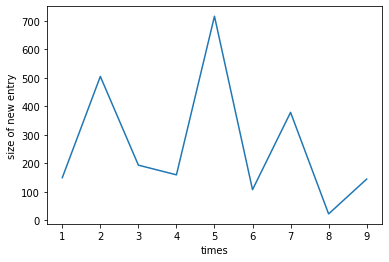

In [378]:
# datasetの上限100, バッチ処理100characterに設定し、ストリーミングを行う
test_09_batch = OptimaizedCompetionBatch(test_09_competition, streaming_iters=getDataSourceFromWikipedia(limit=20, show_received_log=False), batch_character_size=200)
test_09_batch.start(reset_cache=True, plot_entry_rates=True, show_batch_log=True, show_api_log=True) #ストリーミング処理を開始

In [ ]:
# datasetの上限100, バッチ処理100characterに設定し、ストリーミングを行う
test_09_epochs = 5
test_09_entry_counts = []
test_09_error_counts = []
test_09_spend_times = []

for epoch in range(test_09_epochs):
  print("start epoch #"+str(epoch))
  #開始時刻を記録
  start_time = datetime.datetime.now().timestamp()

  #バッチ処理開始
  batch = OptimaizedCompetionBatch(test_09_competition, streaming_iters=getDataSourceFromWikipedia(limit=15, show_received_log=False), batch_character_size=200)
  entry_count, error_count = batch.start(plot_entry_rates=False, show_batch_log=False, show_api_log=False) #ストリーミング処理を開始

  #結果を追加
  test_09_entry_counts.append(entry_count)
  test_09_error_counts.append(error_count)
  end_time = datetime.datetime.now().timestamp() - start_time
  test_09_spend_times.append(end_time)

test_09_entry_counts = np.array(test_09_entry_counts)
test_09_error_counts = np.array(test_09_error_counts)
test_09_spend_times = np.array(test_09_spend_times)

print("----------")
print("epoch:", test_09_epochs)
print("avarage entry count (+var): {:.3f} vocabs ({:.3f})".format(np.average(test_09_entry_counts), np.std(test_09_entry_counts)))
print("avarage error count (+var): {:.3f} errors ({:.3f})".format(np.average(test_09_error_counts), np.std(test_09_error_counts)))
print("avarage error count (+var): {:.3f}%".format((np.average(test_09_error_counts) + 1e-9) / (np.average(test_09_entry_counts)+ 1e-9 ) * 100.0))
print("avarage spend time  (+var): {:.3f} sec    ({:.3f})".format(np.average(test_09_spend_times), np.std(test_09_spend_times)))

start epoch #0
-------------
vocab count: 3000
error count 39
hit percentage 1.30%
start epoch #1
-------------
vocab count: 5081
error count 112
hit percentage 2.20%
start epoch #2
-------------
vocab count: 5868
error count 71
hit percentage 1.21%
start epoch #3
params error: {'id': '1663488586.854218', 'jsonrpc': '2.0', 'method': 'jlp.furiganaservice.furigana', 'params': {'q': '絵葉書。陽三。和室。防音。⻘年。⻑塚。畑町。常世田。⻄⻘。⻄部。射座。市庭。診査。台町。山高。増圧。水洗。土合。'}}
'result'
params error: {'id': '1663488608.523666', 'jsonrpc': '2.0', 'method': 'jlp.furiganaservice.furigana', 'params': {'q': '絵葉書。陽三。和室。防音。⻘年。⻑塚。畑町。常世田。⻄⻘。⻄部。射座。'}}
'result'
-------------
vocab count: 11686
error count 164
hit percentage 1.40%
start epoch #4
params error: {'id': '1663488701.916781', 'jsonrpc': '2.0', 'method': 'jlp.furiganaservice.furigana', 'params': {'q': '脛骨。刀創。顳顬。頂部。指端。陰嚢。俊才。驍将。才幹。無様。人真。鞆之助。剥出し。付合。世人。乾分。世情。淡泊。貴賤。市来。廉潔。豪胆。百折。不撓。仁慈。名利。酒食。食言。親疎。食客。不才。深謀。武断。春山。彌次郎。倉岡。'}}
'result'
params error: {'id': '1663488702.705655', 'jsonrpc':